## Imports

In [ ]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=a5624c1c54deb7616a8fce206870c825677c37a65db27fa42dd095165bddc92e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 120 kB 57.5 MB/s 
     |████████████████████████████████| 6.6 MB 39.7 MB/s 


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.3 MB/s 


In [ ]:
!pip install torch==1.12.0
!pip install torchtext==0.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.3 MB 18 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.12.0 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.12.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.12.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.2 MB/s 
  Attempting uninstall: torchtext
    Found existing insta

In [ ]:
!pip install torchdata==0.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 140 kB 35.2 MB/s 
     |████████████████████████████████| 127 kB 51.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import os
import sys
import wget 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import transformers as ppb
import random
import warnings
import math
import copy
from packaging import version
from torch import Tensor, nn
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tqdm
from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
from torchtext.datasets import Multi30k

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MarianConfig, PreTrainedModel
from transformers.modeling_outputs import BaseModelOutput, BaseModelOutputWithPastAndCrossAttentions, Seq2SeqModelOutput, Seq2SeqLMOutput

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/HBFPEmulator/bfp")

In [ ]:
from bfp_ops import BFPLinear, BFPConv2d, unpack_bfp_args, _get_bfp_op, float_to_bfp_tiled

In [ ]:
from bfp_optim import _gen_bfp_optim

In [ ]:
from bfp_optim_lstm import BFPAdam

In [ ]:
from typing import Dict, List, Optional, Tuple, Union

In [ ]:
from transformers.models.marian.modeling_marian import _expand_mask, _make_causal_mask, shift_tokens_right

In [ ]:
from transformers.models.marian.modeling_marian import MarianSinusoidalPositionalEmbedding

In [ ]:
from transformers.activations import get_activation, ACT2FN, SiLUActivation

## Activation

## Baseline for MT + utility functions

In [ ]:
train_iter = Multi30k(split="train")

# torchtext.datasets.DatasetName yield exhaustible IterableDataset.
# To fix this we convert our dataset to a list.
train_data = list(train_iter)

print(f"Number of training examples: {len(train_data)}")
print(train_data[0])

Number of training examples: 29001
('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 'Two young, White males are outside near many bushes.')


In [ ]:
train_data_1 = train_data[:14500]
train_data_2 = train_data[14500:29000]
print(len(train_data_1))
print(len(train_data_2))

14500
14500


In [ ]:
test_iter = Multi30k(split="test")
test_data = list(test_iter)
print(f"Number of test examples: {len(test_data)}")
print(test_data[0])

Number of test examples: 1000
('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.', 'A man in an orange hat starring at something.')


In [ ]:
test_data_1 = test_data[:500]
test_data_2 = test_data[500:1000]
print(len(test_data_1))
print(len(test_data_2))

500
500


In [ ]:
model_name = 'Helsinki-NLP/opus-mt-de-en'
tokenizer = AutoTokenizer.from_pretrained(model_name)
native_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [ ]:
if torch.cuda.is_available():     
    device = torch.device("cuda")
    print("GPU is available!")
else:
    device = torch.device("cpu")
native_model = native_model.to(device)

In [ ]:
native_model

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(58101, 512, padding_idx=58100)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(58101, 512, padding_idx=58100)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0): MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1

In [ ]:
def prepare_data(train_data, test_data):
    src_train_raw = []
    dst_train_raw = []
    src_val_raw = []
    dst_val_raw = []  
    for line in train_data:
        src_train_raw.append(line[1].lower())
        dst_train_raw.append(line[0].lower()) 
    for line in test_data:
        src_val_raw.append(line[1].lower())
        dst_val_raw.append(line[0].lower())
    src_train = tokenizer(src_train_raw, padding=True, truncation=True, return_tensors="pt")
    dest_train = tokenizer(dst_train_raw, padding=True, truncation=True, return_tensors="pt")
    src_val = tokenizer(src_val_raw, padding=True, truncation=True, return_tensors="pt")
    dest_val = tokenizer(dst_val_raw, padding=True, truncation=True, return_tensors="pt")
    return src_train, dest_train, src_val, dest_val

In [ ]:
src_train_1, dest_train_1, src_val_1, dest_val_1 = prepare_data(train_data_1, test_data_1)
src_train_2, dest_train_2, src_val_2, dest_val_2 = prepare_data(train_data_2, test_data_2)

In [ ]:
def estimate_bleu(model, inp_idx, out_idx, batch_size):
    tokenizer_W = WordPunctTokenizer()
    with torch.no_grad():
        translations = []
        inp_idx = inp_idx.to(device)
        prev_i = 0
        for i in tqdm.notebook.tqdm(range(batch_size, len(inp_idx) + batch_size, batch_size)):
            output = model.generate(inp_idx[prev_i:i]).cpu()
            prev_i = i
            translations.extend(tokenizer.batch_decode(output, skip_special_tokens=True))
        actual = tokenizer.batch_decode(out_idx, skip_special_tokens=True)
        return corpus_bleu(
            [[tokenizer_W.tokenize(ref)] for ref in actual],
            [tokenizer_W.tokenize(trans.lower()) for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [ ]:
print(native_model.config)

MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-de-en",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      58100
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 58100,
  "decoder_vocab_size": 58101,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_length": 5

## Quantized model

In [ ]:
config = MarianConfig(activation_dropout=native_model.config.activation_dropout,
activation_function=native_model.config.activation_function,
attention_dropout=native_model.config.attention_dropout,
classifier_dropout=native_model.config.classifier_dropout,
d_model=native_model.config.d_model,
decoder_attention_heads=native_model.config.decoder_attention_heads,
decoder_ffn_dim=native_model.config.decoder_ffn_dim,
decoder_layerdrop=native_model.config.decoder_layerdrop,
decoder_layers=native_model.config.decoder_layers,
decoder_start_token_id=native_model.config.decoder_start_token_id,
decoder_vocab_size=native_model.config.decoder_vocab_size,
dropout=native_model.config.dropout,
encoder_attention_heads=native_model.config.encoder_attention_heads,
encoder_ffn_dim=native_model.config.encoder_ffn_dim,
encoder_layerdrop=native_model.config.encoder_layerdrop,
encoder_layers=native_model.config.encoder_layers,
eos_token_id=native_model.config.eos_token_id,
forced_eos_token_id=native_model.config.forced_eos_token_id,
init_std=native_model.config.init_std,
is_encoder_decoder=native_model.config.is_encoder_decoder,
max_position_embeddings=native_model.config.max_position_embeddings,
model_type=native_model.config.model_type,
num_hidden_layers=native_model.config.num_hidden_layers,
pad_token_id=native_model.config.pad_token_id,
scale_embedding=native_model.config.scale_embedding,
share_encoder_decoder_embeddings=native_model.config.share_encoder_decoder_embeddings,
transformers_version=native_model.config.transformers_version,
use_cache=native_model.config.use_cache,
vocab_size=native_model.config.vocab_size)

In [ ]:
def BFPbmm(mat1, mat2, bfp_args={}):
    if bfp_args["num_format"] == "bfp":
        op = _get_bfp_op(torch.bmm, "bmm", bfp_args)
    else:
        op = torch.bmm
    return op(mat1, mat2)

In [ ]:
class BFPMarianAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        is_decoder: bool = False,
        bias: bool = True,
        bfp_args={}
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        self.bfp_args = bfp_args

        if (self.head_dim * num_heads) != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim}"
                f" and `num_heads`: {num_heads})."
            )
        self.scaling = self.head_dim**-0.5
        self.is_decoder = is_decoder

        self.k_proj = BFPLinear(embed_dim, embed_dim, bias=bias, **bfp_args)
        self.v_proj = BFPLinear(embed_dim, embed_dim, bias=bias, **bfp_args)
        self.q_proj = BFPLinear(embed_dim, embed_dim, bias=bias, **bfp_args)
        self.out_proj = BFPLinear(embed_dim, embed_dim, bias=bias, **bfp_args)


    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(
        self,
        hidden_states: torch.Tensor,
        key_value_states: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None

        bsz, tgt_len, _ = hidden_states.size()

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scaling
        # get key, value proj
        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_states = past_key_value[0]
            value_states = past_key_value[1]
        elif is_cross_attention:
            # cross_attentions
            key_states = self._shape(self.k_proj(key_value_states), -1, bsz)
            value_states = self._shape(self.v_proj(key_value_states), -1, bsz)
        elif past_key_value is not None:
            # reuse k, v, self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)
        else:
            # self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

        if self.is_decoder:
            past_key_value = (key_states, value_states)

        proj_shape = (bsz * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
        key_states = key_states.view(*proj_shape)
        value_states = value_states.view(*proj_shape)

        src_len = key_states.size(1)
        attn_weights = BFPbmm(query_states, key_states.transpose(1, 2), self.bfp_args)

        if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
                )
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + attention_mask
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        if layer_head_mask is not None:
            if layer_head_mask.size() != (self.num_heads,):
                raise ValueError(
                    f"Head mask for a single layer should be of size {(self.num_heads,)}, but is"
                    f" {layer_head_mask.size()}"
                )
            attn_weights = layer_head_mask.view(1, -1, 1, 1) * attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if output_attentions:
            attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, tgt_len, src_len)
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)
        attn_output = BFPbmm(attn_probs, value_states, self.bfp_args)

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)

        attn_output = attn_output.reshape(bsz, tgt_len, self.embed_dim)

        attn_output = self.out_proj(attn_output)
        return attn_output, attn_weights_reshaped, past_key_value


In [ ]:
class BFPMarianEncoderLayer(nn.Module):
    def __init__(self, config: MarianConfig, bfp_args={}):
        super().__init__()
        # self.embed_dim = config.d_model
        self.embed_dim = 512
        self.self_attn = BFPMarianAttention(
            embed_dim=self.embed_dim,
            num_heads=8,
            dropout=0.0,
            bfp_args=bfp_args
        )
        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.dropout = 0.1

        self.activation_fn = ACT2FN["swish"]
        self.activation_dropout = 0.0
        self.fc1 = BFPLinear(self.embed_dim, 2048, **bfp_args)
        self.fc2 = BFPLinear(2048, self.embed_dim, **bfp_args)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.FloatTensor,
        attention_mask: torch.FloatTensor,
        layer_head_mask: torch.FloatTensor,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.FloatTensor, Optional[torch.FloatTensor]]:
      
        residual = hidden_states
        hidden_states, attn_weights, _ = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        residual = hidden_states
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)

        if hidden_states.dtype == torch.float16 and (
            torch.isinf(hidden_states).any() or torch.isnan(hidden_states).any()
        ):
            clamp_value = torch.finfo(hidden_states.dtype).max - 1000
            hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (attn_weights,)

        return outputs

In [ ]:
class BFPMarianPreTrainedModel(PreTrainedModel):
    # config_class = MarianConfig
    base_model_prefix = "model"
    supports_gradient_checkpointing = True

    def _init_weights(self, module: Union[nn.Linear, nn.Embedding, MarianSinusoidalPositionalEmbedding]):
        std = 0.02
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, MarianSinusoidalPositionalEmbedding):
            pass
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()

    def _set_gradient_checkpointing(self, module, value=False):
        if isinstance(module, (BFPMarianDecoder, BFPMarianEncoder)):
            module.gradient_checkpointing = value

    @property
    def dummy_inputs(self):
        pad_token = 58100
        input_ids = torch.tensor([[0, 6, 10, 4, 2], [0, 8, 12, 2, pad_token]], device=self.device)
        dummy_inputs = {
            "attention_mask": input_ids.ne(pad_token),
            "input_ids": input_ids,
            "decoder_input_ids": input_ids,
        }
        return dummy_inputs

In [ ]:
class BFPMarianEncoder(BFPMarianPreTrainedModel):
    """
    Transformer encoder consisting of *config.encoder_layers* self attention layers. Each layer is a
    [`MarianEncoderLayer`].
    Args:
        config: MarianConfig
        embed_tokens (nn.Embedding): output embedding
    """

    def __init__(self, config: MarianConfig, embed_tokens: Optional[nn.Embedding] = None, bfp_args={}):
        super().__init__(config, bfp_args)

        self.dropout = config.dropout
        self.layerdrop = config.encoder_layerdrop

        embed_dim = config.d_model
        self.padding_idx = config.pad_token_id
        self.max_source_positions = config.max_position_embeddings
        self.embed_scale = math.sqrt(embed_dim) if config.scale_embedding else 1.0

        if embed_tokens is not None:
            self.embed_tokens = embed_tokens
        else:
            self.embed_tokens = nn.Embedding(config.vocab_size, embed_dim, self.padding_idx)

        self.embed_positions = MarianSinusoidalPositionalEmbedding(
            config.max_position_embeddings, embed_dim, self.padding_idx
        )
        self.layers = nn.ModuleList([BFPMarianEncoderLayer(config, bfp_args) for _ in range(config.encoder_layers)])

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embed_tokens

    def set_input_embeddings(self, value):
        self.embed_tokens = value

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutput]:
   
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # retrieve input_ids and inputs_embeds
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids) * self.embed_scale

        embed_pos = self.embed_positions(input_shape)

        hidden_states = inputs_embeds + embed_pos
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _expand_mask(attention_mask, inputs_embeds.dtype)

        encoder_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None

        # check if head_mask has a correct number of layers specified if desired
        if head_mask is not None:
            assert head_mask.size()[0] == (
                len(self.layers)
            ), f"The head_mask should be specified for {len(self.layers)} layers, but it is for {head_mask.size()[0]}."
        for idx, encoder_layer in enumerate(self.layers):
            if output_hidden_states:
                encoder_states = encoder_states + (hidden_states,)
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.layerdrop):  # skip the layer
                layer_outputs = (None, None)
            else:
                if self.gradient_checkpointing and self.training:

                    def create_custom_forward(module):
                        def custom_forward(*inputs):
                            return module(*inputs, output_attentions)

                        return custom_forward

                    layer_outputs = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(encoder_layer),
                        hidden_states,
                        attention_mask,
                        (head_mask[idx] if head_mask is not None else None),
                    )
                else:
                    layer_outputs = encoder_layer(
                        hidden_states,
                        attention_mask,
                        layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                        output_attentions=output_attentions,
                    )

                hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        if output_hidden_states:
            encoder_states = encoder_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, encoder_states, all_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states, hidden_states=encoder_states, attentions=all_attentions
        )

In [ ]:
class BFPMarianDecoderLayer(nn.Module):
    def __init__(self, config: MarianConfig, bfp_args={}):
        super().__init__()
        self.embed_dim = config.d_model

        self.self_attn = BFPMarianAttention(
            embed_dim=self.embed_dim,
            num_heads=config.decoder_attention_heads,
            dropout=config.attention_dropout,
            is_decoder=True,
            bfp_args=bfp_args
        )
        self.dropout = config.dropout
        self.activation_fn = ACT2FN["swish"]
        self.activation_dropout = config.activation_dropout

        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.encoder_attn = BFPMarianAttention(
            self.embed_dim,
            config.decoder_attention_heads,
            dropout=config.attention_dropout,
            is_decoder=True,
            bfp_args=bfp_args
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.fc1 = BFPLinear(self.embed_dim, config.decoder_ffn_dim, **bfp_args)
        self.fc2 = BFPLinear(config.decoder_ffn_dim, self.embed_dim, **bfp_args)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        cross_attn_layer_head_mask: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = True,
    ) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:
      
        residual = hidden_states

        # Self Attention
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        # add present self-attn cache to positions 1,2 of present_key_value tuple
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            past_key_value=self_attn_past_key_value,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        # Cross-Attention Block
        cross_attn_present_key_value = None
        cross_attn_weights = None
        if encoder_hidden_states is not None:
            residual = hidden_states

            # cross_attn cached key/values tuple is at positions 3,4 of present_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            hidden_states, cross_attn_weights, cross_attn_present_key_value = self.encoder_attn(
                hidden_states=hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                layer_head_mask=cross_attn_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                output_attentions=output_attentions,
            )
            hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
            hidden_states = residual + hidden_states
            hidden_states = self.encoder_attn_layer_norm(hidden_states)

            # add cross-attn to positions 3,4 of present_key_value tuple
            present_key_value = present_key_value + cross_attn_present_key_value

        # Fully Connected
        residual = hidden_states
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights, cross_attn_weights)

        if use_cache:
            outputs += (present_key_value,)

        return outputs

In [ ]:
class BFPMarianDecoder(BFPMarianPreTrainedModel):
    """
    Transformer decoder consisting of *config.decoder_layers* layers. Each layer is a [`MarianDecoderLayer`]
    Args:
        config: MarianConfig
        embed_tokens (nn.Embedding): output embedding
    """

    def __init__(self, config: MarianConfig, embed_tokens: Optional[nn.Embedding] = None, bfp_args={}):
        super().__init__(config, bfp_args)
        self.dropout = config.dropout
        self.layerdrop = config.decoder_layerdrop
        self.padding_idx = config.pad_token_id
        self.max_target_positions = config.max_position_embeddings
        self.embed_scale = math.sqrt(config.d_model) if config.scale_embedding else 1.0

        if embed_tokens is not None:
            self.embed_tokens = embed_tokens
        else:
            self.embed_tokens = nn.Embedding(config.decoder_vocab_size, config.d_model, self.padding_idx)

        self.embed_positions = MarianSinusoidalPositionalEmbedding(
            config.max_position_embeddings, config.d_model, self.padding_idx
        )
        self.layers = nn.ModuleList([BFPMarianDecoderLayer(config, bfp_args) for _ in range(config.decoder_layers)])

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embed_tokens

    def set_input_embeddings(self, value):
        self.embed_tokens = value

    # Copied from transformers.models.bart.modeling_bart.BartDecoder._prepare_decoder_attention_mask
    def _prepare_decoder_attention_mask(self, attention_mask, input_shape, inputs_embeds, past_key_values_length):
        # create causal mask
        # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
        combined_attention_mask = None
        if input_shape[-1] > 1:
            combined_attention_mask = _make_causal_mask(
                input_shape, inputs_embeds.dtype, past_key_values_length=past_key_values_length
            ).to(inputs_embeds.device)

        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            expanded_attn_mask = _expand_mask(attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1])
            combined_attention_mask = (
                expanded_attn_mask if combined_attention_mask is None else expanded_attn_mask + combined_attention_mask
            )

        return combined_attention_mask

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPastAndCrossAttentions]:
       
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # retrieve input_ids and inputs_embeds
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both decoder_input_ids and decoder_inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either decoder_input_ids or decoder_inputs_embeds")

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids) * self.embed_scale

        attention_mask = self._prepare_decoder_attention_mask(
            attention_mask, input_shape, inputs_embeds, past_key_values_length
        )

        # expand encoder attention mask
        if encoder_hidden_states is not None and encoder_attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            encoder_attention_mask = _expand_mask(encoder_attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1])

        # embed positions
        positions = self.embed_positions(input_shape, past_key_values_length)

        hidden_states = inputs_embeds + positions

        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
        all_cross_attentions = () if (output_attentions and encoder_hidden_states is not None) else None
        next_decoder_cache = () if use_cache else None

        # check if head_mask/cross_attn_head_mask has a correct number of layers specified if desired
        for attn_mask, mask_name in zip([head_mask, cross_attn_head_mask], ["head_mask", "cross_attn_head_mask"]):
            if attn_mask is not None:
                assert attn_mask.size()[0] == (len(self.layers)), (
                    f"The `{mask_name}` should be specified for {len(self.layers)} layers, but it is for"
                    f" {head_mask.size()[0]}."
                )
        for idx, decoder_layer in enumerate(self.layers):
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            if output_hidden_states:
                all_hidden_states += (hidden_states,)
            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.layerdrop):
                continue

            past_key_value = past_key_values[idx] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:

                if use_cache:
                    # logger.warning(
                        # "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                    # )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        # None for past_key_value
                        return module(*inputs, output_attentions, use_cache)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(decoder_layer),
                    hidden_states,
                    attention_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    head_mask[idx] if head_mask is not None else None,
                    cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None,
                    None,
                )
            else:

                layer_outputs = decoder_layer(
                    hidden_states,
                    attention_mask=attention_mask,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_attention_mask,
                    layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                    cross_attn_layer_head_mask=(
                        cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None
                    ),
                    past_key_value=past_key_value,
                    output_attentions=output_attentions,
                    use_cache=use_cache,
                )
            hidden_states = layer_outputs[0]

            if use_cache:
                next_decoder_cache += (layer_outputs[3 if output_attentions else 1],)

            if output_attentions:
                all_self_attns += (layer_outputs[1],)

                if encoder_hidden_states is not None:
                    all_cross_attentions += (layer_outputs[2],)

        # add hidden states from the last decoder layer
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        next_cache = next_decoder_cache if use_cache else None
        if not return_dict:
            return tuple(
                v
                for v in [hidden_states, next_cache, all_hidden_states, all_self_attns, all_cross_attentions]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attns,
            cross_attentions=all_cross_attentions,
        )

In [ ]:
class BFPMarianModel(BFPMarianPreTrainedModel):
    def __init__(self, config: MarianConfig, bfp_args={}):
        super().__init__(config)

        padding_idx, vocab_size = config.pad_token_id, config.vocab_size

        # We always use self.shared for token embeddings to ensure compatibility with all marian models
        self.shared = nn.Embedding(vocab_size, config.d_model, padding_idx)
        encoder_embed_tokens = decoder_embed_tokens = self.shared

        self.encoder = BFPMarianEncoder(config, encoder_embed_tokens, bfp_args)
        self.decoder = BFPMarianDecoder(config, decoder_embed_tokens, bfp_args)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        # This will return shared embeddings if they are shared else specific to encoder.
        return self.get_encoder().get_input_embeddings()

    def set_input_embeddings(self, value):
        if self.config.share_encoder_decoder_embeddings:
            self.shared = value
            self.encoder.embed_tokens = self.shared
            self.decoder.embed_tokens = self.shared
        else:  # if not shared only set encoder embeedings
            self.encoder.embed_tokens = value

    def get_decoder_input_embeddings(self):
        if self.config.share_encoder_decoder_embeddings:
            raise ValueError(
                "`get_decoder_input_embeddings` should not be called if `config.share_encoder_decoder_embeddings` "
                "is `True`. Please use `get_input_embeddings` instead."
            )
        return self.get_decoder().get_input_embeddings()

    def set_decoder_input_embeddings(self, value):
        if self.config.share_encoder_decoder_embeddings:
            raise ValueError(
                "`config.share_encoder_decoder_embeddings` is set to `True` meaning the decoder input embeddings "
                "are shared with the encoder. In order to set the decoder input embeddings, you should simply set "
                "the encoder input embeddings by calling `set_input_embeddings` with the appropriate embeddings."
            )
        self.decoder.embed_tokens = value

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    def resize_decoder_token_embeddings(self, new_num_tokens: int) -> nn.Embedding:
        if self.config.share_encoder_decoder_embeddings:
            raise ValueError(
                "`resize_decoder_token_embeddings` should not be called if `config.share_encoder_decoder_embeddings` "
                "is `True`. Please use `resize_token_embeddings` instead."
            )

        old_embeddings = self.get_decoder_input_embeddings()
        new_embeddings = self._get_resized_embeddings(old_embeddings, new_num_tokens)
        self.set_decoder_input_embeddings(new_embeddings)

        model_embeds = self.get_decoder_input_embeddings()

        if new_num_tokens is None:
            return model_embeds

        # Update base model and current model config
        self.config.decoder_vocab_size = new_num_tokens

        # Tie weights again if needed
        self.tie_weights()

        return model_embeds

    # @add_start_docstrings_to_model_forward(MARIAN_INPUTS_DOCSTRING)
    # @replace_return_docstrings(output_type=Seq2SeqModelOutput, config_class=_CONFIG_FOR_DOC)
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Union[Tuple[torch.Tensor], BaseModelOutput]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Seq2SeqModelOutput:
        
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                head_mask=head_mask,
                inputs_embeds=inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
        # If the user passed a tuple for encoder_outputs, we wrap it in a BaseModelOutput when return_dict=True
        elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
            encoder_outputs = BaseModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
            )

        # decoder outputs consists of (dec_features, past_key_value, dec_hidden, dec_attn)
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=encoder_outputs[0],
            encoder_attention_mask=attention_mask,
            head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            inputs_embeds=decoder_inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        if not return_dict:
            return decoder_outputs + encoder_outputs

        return Seq2SeqModelOutput(
            last_hidden_state=decoder_outputs.last_hidden_state,
            past_key_values=decoder_outputs.past_key_values,
            decoder_hidden_states=decoder_outputs.hidden_states,
            decoder_attentions=decoder_outputs.attentions,
            cross_attentions=decoder_outputs.cross_attentions,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
        )


      # @add_start_docstrings(
   # "The Marian Model with a language modeling head. Can be used for summarization.", MARIAN_START_DOCSTRING
# )

In [ ]:
class BFPMarianMTModel(BFPMarianPreTrainedModel):
    base_model_prefix = "model"
    _keys_to_ignore_on_load_missing = [
        r"final_logits_bias",
        r"encoder.version",
        r"decoder.version",
        r"lm_head.weight",
        r"embed_positions",
    ]

    _keys_to_ignore_on_save = ["model.encoder.embed_positions.weight", "model.decoder.embed_positions.weight"]

    def __init__(self, config: MarianConfig, bfp_args={}):
        super().__init__(config)
        self.model = BFPMarianModel(config, bfp_args)

        target_vocab_size = config.vocab_size if config.share_encoder_decoder_embeddings else config.decoder_vocab_size
        self.register_buffer("final_logits_bias", torch.zeros((1, target_vocab_size)))
        self.lm_head = BFPLinear(512, target_vocab_size, bias=False, bfp_args = bfp_args)

        # Initialize weights and apply final processing
        self.post_init()

    def get_encoder(self):
        return self.model.get_encoder()

    def get_decoder(self):
        return self.model.get_decoder()

    def resize_token_embeddings(self, new_num_tokens: int) -> nn.Embedding:
        new_embeddings = super().resize_token_embeddings(new_num_tokens)
        if self.config.share_encoder_decoder_embeddings:
            self._resize_final_logits_bias(new_num_tokens)
        return new_embeddings

    def _resize_token_embeddings(self, new_num_tokens: int) -> nn.Embedding:
        old_embeddings = self.get_input_embeddings()
        new_embeddings = self._get_resized_embeddings(old_embeddings, new_num_tokens)
        self.set_input_embeddings(new_embeddings)

        # update config.decoder_vocab_size if embeddings are tied
        if self.config.share_encoder_decoder_embeddings:
            self.config.decoder_vocab_size = new_num_tokens

        # if word embeddings are not tied, make sure that lm head is resized as well
        if (
            self.config.share_encoder_decoder_embeddings
            and self.get_output_embeddings() is not None
            and not self.config.tie_word_embeddings
        ):
            old_lm_head = self.get_output_embeddings()
            new_lm_head = self._get_resized_lm_head(old_lm_head, new_num_tokens)
            self.set_output_embeddings(new_lm_head)

        return self.get_input_embeddings()

    def resize_decoder_token_embeddings(self, new_num_tokens):
        if self.config.share_encoder_decoder_embeddings:
            raise ValueError(
                "`resize_decoder_token_embeddings` should not be called if `config.share_encoder_decoder_embeddings` "
                "is `True`. Please use `resize_token_embeddings` instead."
            )

        old_embeddings = self.model.get_decoder_input_embeddings()
        new_embeddings = self._get_resized_embeddings(old_embeddings, new_num_tokens)
        self.model.set_decoder_input_embeddings(new_embeddings)

        # if word embeddings are not tied, make sure that lm head is resized as well
        if self.get_output_embeddings() is not None and not self.config.tie_word_embeddings:
            old_lm_head = self.get_output_embeddings()
            new_lm_head = self._get_resized_lm_head(old_lm_head, new_num_tokens)
            self.set_output_embeddings(new_lm_head)

        model_embeds = self.model.get_decoder_input_embeddings()

        if new_num_tokens is None:
            return model_embeds

        # Update base model and current model config
        self.config.decoder_vocab_size = new_num_tokens

        # Tie weights again if needed
        self.tie_weights()

        self._resize_final_logits_bias(new_num_tokens)

        return model_embeds

    def _resize_final_logits_bias(self, new_num_tokens: int) -> None:
        old_num_tokens = self.final_logits_bias.shape[-1]
        if new_num_tokens <= old_num_tokens:
            new_bias = self.final_logits_bias[:, :new_num_tokens]
        else:
            extra_bias = torch.zeros((1, new_num_tokens - old_num_tokens), device=self.final_logits_bias.device)
            new_bias = torch.cat([self.final_logits_bias, extra_bias], dim=1)
        self.register_buffer("final_logits_bias", new_bias)

    def get_output_embeddings(self):
        return self.lm_head

    def set_output_embeddings(self, new_embeddings: nn.Embedding):
        self.lm_head = new_embeddings

    def tie_weights(self):
        """
        Tie the weights between the input embeddings and the output embeddings.
        If the `torchscript` flag is set in the configuration, can't handle parameter sharing so we are cloning the
        weights instead.
        """
        output_embeddings = self.get_output_embeddings()
        if output_embeddings is not None and getattr(self.config, "tie_word_embeddings", True):
            # if embeddings are shared this will return shared embeddings otherwise decoder embed_tokens
            word_embeddings = self.get_decoder().get_input_embeddings()
            self._tie_or_clone_weights(output_embeddings, word_embeddings)

        if getattr(self.config, "is_encoder_decoder", False) and getattr(self.config, "tie_encoder_decoder", False):
            if hasattr(self, self.base_model_prefix):
                self = getattr(self, self.base_model_prefix)
            self._tie_encoder_decoder_weights(self.encoder, self.decoder, self.base_model_prefix)

        for module in self.modules():
            if hasattr(module, "_tie_weights"):
                module._tie_weights()

    # @add_start_docstrings_to_model_forward(MARIAN_INPUTS_DOCSTRING)
    # @replace_return_docstrings(output_type=Seq2SeqLMOutput, config_class=_CONFIG_FOR_DOC)
    # @add_end_docstrings(MARIAN_GENERATION_EXAMPLE)
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Union[Tuple[torch.Tensor], BaseModelOutput]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Seq2SeqLMOutput:
       
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if labels is not None:
            use_cache = False
            if decoder_input_ids is None:
                decoder_input_ids = shift_tokens_right(
                    labels, self.config.pad_token_id, self.config.decoder_start_token_id
                )

        outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            encoder_outputs=encoder_outputs,
            decoder_attention_mask=decoder_attention_mask,
            head_mask=head_mask,
            decoder_head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            decoder_inputs_embeds=decoder_inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        lm_logits = self.lm_head(outputs[0]) + self.final_logits_bias

        masked_lm_loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            masked_lm_loss = loss_fct(lm_logits.view(-1, 58101), labels.view(-1))

        if not return_dict:
            output = (lm_logits,) + outputs[1:]
            return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

        return Seq2SeqLMOutput(
            loss=masked_lm_loss,
            logits=lm_logits,
            past_key_values=outputs.past_key_values,
            decoder_hidden_states=outputs.decoder_hidden_states,
            decoder_attentions=outputs.decoder_attentions,
            cross_attentions=outputs.cross_attentions,
            encoder_last_hidden_state=outputs.encoder_last_hidden_state,
            encoder_hidden_states=outputs.encoder_hidden_states,
            encoder_attentions=outputs.encoder_attentions,
        )

    def prepare_inputs_for_generation(
        self,
        decoder_input_ids: torch.LongTensor,
        past: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = None,
        encoder_outputs: Optional[Union[Tuple[torch.Tensor], BaseModelOutput]] = None,
        **kwargs,
    ) -> Dict:
        # cut decoder_input_ids if past is used
        if past is not None:
            decoder_input_ids = decoder_input_ids[:, -1:]

        return {
            "input_ids": None,  # encoder_outputs is defined. input_ids not needed
            "encoder_outputs": encoder_outputs,
            "past_key_values": past,
            "decoder_input_ids": decoder_input_ids,
            "attention_mask": attention_mask,
            "head_mask": head_mask,
            "decoder_head_mask": decoder_head_mask,
            "cross_attn_head_mask": cross_attn_head_mask,
            "use_cache": use_cache,  # change this to avoid caching (presumably for debugging)
        }

    def prepare_decoder_input_ids_from_labels(self, labels: torch.Tensor):
        return shift_tokens_right(labels, self.config.pad_token_id, self.config.decoder_start_token_id)

    def adjust_logits_during_generation(self, logits, cur_len):
        logits[:, self.config.pad_token_id] = float("-inf")  # never predict pad token.
        return logits

    @staticmethod
    def _reorder_cache(past, beam_idx):
        reordered_past = ()
        for layer_past in past:
            # cached cross_attention states don't have to be reordered -> they are always the same
            reordered_past += (
                tuple(past_state.index_select(0, beam_idx) for past_state in layer_past[:2]) + layer_past[2:],
            )
        return reordered_past


In [ ]:
# bfp quantization arguments
args = {"num_format": "bfp", "rounding_mode": "stoc", "mant_bits": 8, 
       "bfp_tile_size": 0, "weight_mant_bits": 16, "device": "gpu", "epsilon": 1e-8}
model_1 = BFPMarianMTModel(config, args)
model_2 = BFPMarianMTModel(config, args)

## Quantized model vs basic model

Load pretrained MarianMT model from transformers and estimate its score

In [ ]:
train_ids_1 = dest_train_1["input_ids"]
train_labels_1 = src_train_1["input_ids"]
train_mask_1 = dest_train_1["attention_mask"] 
val_ids_1 = dest_val_1["input_ids"]
val_labels_1 = src_val_1["input_ids"]
val_mask_1 = dest_val_1["attention_mask"]

In [ ]:
train_ids_2 = dest_train_2["input_ids"]
train_labels_2 = src_train_2["input_ids"]
train_mask_2 = dest_train_2["attention_mask"] 
val_ids_2 = dest_val_2["input_ids"]
val_labels_2 = src_val_2["input_ids"]
val_mask_2 = dest_val_2["attention_mask"]

In [ ]:
estimate_bleu(native_model, val_ids_1, val_labels_1, 16)

  0%|          | 0/32 [00:00<?, ?it/s]

35.26688112022937

In [ ]:
torch.save(native_model.state_dict(), "init.pth")

In [ ]:
model_1.load_state_dict(torch.load("init.pth"))
model_1.eval()

BFPMarianMTModel(
  (model): BFPMarianModel(
    (shared): Embedding(58101, 512, padding_idx=58100)
    (encoder): BFPMarianEncoder(
      (embed_tokens): Embedding(58101, 512, padding_idx=58100)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0): BFPMarianEncoderLayer(
          (self_attn): BFPMarianAttention(
            (k_proj): BFPLinear(in_features=512, out_features=512, bias=True)
            (v_proj): BFPLinear(in_features=512, out_features=512, bias=True)
            (q_proj): BFPLinear(in_features=512, out_features=512, bias=True)
            (out_proj): BFPLinear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): BFPLinear(in_features=512, out_features=2048, bias=True)
          (fc2): BFPLinear(in_features=2048, out_features=512, bias=True)
          (final_lay

In [ ]:
model_1 = model_1.to(device)

In [ ]:
train_ids_1 = train_ids_1.to(device)
train_labels_1 = train_labels_1.to(device)
train_mask_1 = train_mask_1.to(device)
val_ids_1 = val_ids_1.to(device)
val_labels_1 = val_labels_1.to(device)
val_mask_1 = val_mask_1.to(device)
estimate_bleu(model_1, val_ids_1, val_labels_1, 16) 

  0%|          | 0/32 [00:00<?, ?it/s]

34.146585485419735

In [ ]:
model_2.load_state_dict(torch.load("init.pth"))
model_2.eval()

BFPMarianMTModel(
  (model): BFPMarianModel(
    (shared): Embedding(58101, 512, padding_idx=58100)
    (encoder): BFPMarianEncoder(
      (embed_tokens): Embedding(58101, 512, padding_idx=58100)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0): BFPMarianEncoderLayer(
          (self_attn): BFPMarianAttention(
            (k_proj): BFPLinear(in_features=512, out_features=512, bias=True)
            (v_proj): BFPLinear(in_features=512, out_features=512, bias=True)
            (q_proj): BFPLinear(in_features=512, out_features=512, bias=True)
            (out_proj): BFPLinear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): BFPLinear(in_features=512, out_features=2048, bias=True)
          (fc2): BFPLinear(in_features=2048, out_features=512, bias=True)
          (final_lay

In [ ]:
model_2 = model_2.to(device)

In [ ]:
train_ids_2 = train_ids_2.to(device)
train_labels_2 = train_labels_2.to(device)
train_mask_2 = train_mask_2.to(device)
val_ids_2 = val_ids_2.to(device)
val_labels_2 = val_labels_2.to(device)
val_mask_2 = val_mask_2.to(device)
estimate_bleu(model_2, val_ids_2, val_labels_2, 16) 

  0%|          | 0/32 [00:00<?, ?it/s]

34.524361433422925

## To do: averaging functions

## Continue training 

In [ ]:
hist_1 = []
hist_2 = []
epochs = 3

lr = 1e-4
optimizer_1 = BFPAdam(model_1.parameters(), lr, **args)
optimizer_2 = BFPAdam(model_2.parameters(), lr, **args)
batch_size = 32

In [ ]:
bleu_1 = []
bleu_2 = []

In [ ]:
from IPython.display import clear_output

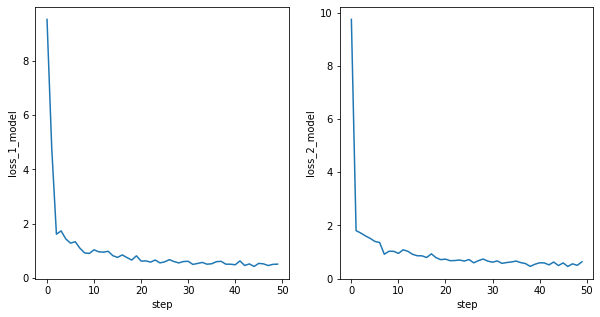

In [ ]:
for epoch in range(epochs):
    model_1.train()
    model_2.train()
    ind = np.arange(len(train_ids_1))
    np.random.shuffle(ind)
    prev_i = 0
    for i in tqdm.notebook.tqdm(np.arange(batch_size, len(train_ids_1), batch_size)):
        step = len(hist_1) + 1
        batch_ind = ind[prev_i:i]
        prev_i = i

        # 1 model training
        optimizer_1.zero_grad()
        outputs_1 = model_1(input_ids=train_ids_1[batch_ind],
                            labels=train_labels_1[batch_ind],
                            attention_mask=train_mask_1[batch_ind])
        loss_1 = outputs_1.loss
        loss_1.backward()
        optimizer_1.step()

        hist_1.append(loss_1.item())

        # 2 model training 
        optimizer_2.zero_grad()
        outputs_2 = model_2(input_ids=train_ids_2[batch_ind],
                            labels=train_labels_2[batch_ind],
                            attention_mask=train_mask_2[batch_ind])
        loss_2 = outputs_2.loss
        loss_2.backward()
        optimizer_2.step()

        hist_2.append(loss_2.item())

        # averaging parameters
        if i % 1000 == 0:
            # to do: BFP averaging!!!
            for (param1, param2) in zip(model_1.parameters(), model_2.parameters()):
                mean = (param1.data + param2.data) / 2
                param1.data = param2.data = mean

        # visualising training losses
        if len(hist_1) % 10 == 0:
            clear_output(wait=True)

            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

            axs[0].plot(hist_1)
            axs[0].set_xlabel("step")
            axs[0].set_ylabel("loss_1_model")
            
            axs[1].plot(hist_2)
            axs[1].set_xlabel("step")
            axs[1].set_ylabel("loss_2_model")

            plt.show()
            
    model_1.eval()
    bleu_1.append(estimate_bleu(model_1, val_ids_1, val_labels_1, 16))
    model_2.eval()
    bleu_2.append(estimate_bleu(model_2, val_ids_2, val_labels_2, 16))        